In [1]:
!pip install -q huggingface_hub
!pip install faiss-cpu
!pip install -q shap
!pip install -q umap-learn
!pip install -q transformers>=4.50.0 accelerate  huggingface_hub


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.8/23.8 MB 79.9 MB/s eta 0:00:00:00:0100:01


In [2]:
import os
import cv2
import time
import umap
import faiss
import torch
import gdown
import random
import kagglehub
import numpy as np
import pandas as pd
from PIL import Image
import seaborn as sns
import tensorflow as tf
from scipy.stats import mode
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from huggingface_hub import snapshot_download, login
from tensorflow.keras import layers, models, callbacks
from sklearn.metrics import confusion_matrix, roc_curve, auc
from transformers import AutoProcessor, AutoModel, AutoModelForImageTextToText


2026-02-23 10:56:40.685090: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1771844200.871984      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771844200.922926      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1771844201.338910      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771844201.338957      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771844201.338960      55 computation_placer.cc:177] computation placer alr

In [3]:
train_emb = "1QyZQLcgQEwpZpEBaMuMSzlrVlaUvkqXA"
train_label = "1ig2b0QLpe3aMxScDE_YkxPaoqndGs3Ro"

val_emb = "1rBXFcqdQy-1jwScd8jlb0YSL-5CgZZBk"
val_label = "177eCaDuBOkGViTnSURZh4a688-z4VJN1"

test_emb = "1KfD_qioCSRg0AD1NBDB2Ch6d_tOBZNfb"
test_label = "1QiW79lxCc4_d2wuj9bL7NJEm88XJ5yjs"

files = {"train_emb":train_emb, "train_label":train_label, "val_emb":val_emb, "val_label":val_label, "test_emb":test_emb, "test_label":test_label}
for file in files:
    url = f"https://drive.google.com/uc?id={files.get(file)}"
    
    gdown.download(url, f"{file}.npy", quiet=False)



Downloading...
From (original): https://drive.google.com/uc?id=1QyZQLcgQEwpZpEBaMuMSzlrVlaUvkqXA
From (redirected): https://drive.google.com/uc?id=1QyZQLcgQEwpZpEBaMuMSzlrVlaUvkqXA&confirm=t&uuid=f5d3a0ee-8526-4ba3-8143-079da7cba1cb
To: /kaggle/working/train_emb.npy
100%|██████████| 945M/945M [00:08<00:00, 106MB/s]  
Downloading...
From: https://drive.google.com/uc?id=1ig2b0QLpe3aMxScDE_YkxPaoqndGs3Ro
To: /kaggle/working/train_label.npy
100%|██████████| 616k/616k [00:00<00:00, 65.4MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1rBXFcqdQy-1jwScd8jlb0YSL-5CgZZBk
From (redirected): https://drive.google.com/uc?id=1rBXFcqdQy-1jwScd8jlb0YSL-5CgZZBk&confirm=t&uuid=f4286e36-37fc-41bf-a14e-b52491ab409e
To: /kaggle/working/val_emb.npy
100%|██████████| 118M/118M [00:01<00:00, 96.2MB/s] 
Downloading...
From: https://drive.google.com/uc?id=177eCaDuBOkGViTnSURZh4a688-z4VJN1
To: /kaggle/working/val_label.npy
100%|██████████| 77.0k/77.0k [00:00<00:00, 62.3MB/s]
Downloading...
Fro

In [1]:
HF_TOKEN = "*****"
login(token=HF_TOKEN)
device = "cuda" if torch.cuda.is_available() else "cpu"

NameError: name 'login' is not defined

In [31]:
try:
    model_path = snapshot_download(repo_id="google/path-foundation")
    print(f"Downloaded to: {model_path}")
    
    path_model = tf.saved_model.load(model_path)
    print("The Google Path Foundation Model is loaded!")

except Exception as e:
    print(f"\nError: {e}")
    print("If this failed, check your Token or make sure you clicked 'Agree' on the Hugging Face page.")

Fetching 8 files:   0%|          | 0/8 [00:00<?, ?it/s]

README.md:   0%|          | 0.00/12.9k [00:00<?, ?B/s]

variables/variables.data-00000-of-00001:   0%|          | 0.00/110M [00:00<?, ?B/s]

keras_metadata.pb:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/1.59k [00:00<?, ?B/s]

fingerprint.pb:   0%|          | 0.00/58.0 [00:00<?, ?B/s]

saved_model.pb:   0%|          | 0.00/3.52M [00:00<?, ?B/s]

Test.png:   0%|          | 0.00/208k [00:00<?, ?B/s]

variables.index:   0%|          | 0.00/3.64k [00:00<?, ?B/s]

Downloaded to: /root/.cache/huggingface/hub/models--google--path-foundation/snapshots/b50f2be6f055ea6ea8719f467ab44b38f37e2142


The Google Path Foundation Model is loaded!


In [6]:
MEDSIGLIP_ID = "google/medsiglip-448" 
try:
    medsiglip_processor = AutoProcessor.from_pretrained(MEDSIGLIP_ID)
    medsiglip_model = AutoModel.from_pretrained(
        MEDSIGLIP_ID, 
        trust_remote_code=True,
        torch_dtype=torch.float16 
    ).to(device)
    
    medsiglip_model.eval()
    print("-> MedSigLIPLoaded Successfully!")

except Exception as e:
    print(f"\n X -> ERROR: Could not load MedSigLIP. Reason: {e}")

preprocessor_config.json:   0%|          | 0.00/360 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/809 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/455 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.40M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/879 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/3.51G [00:00<?, ?B/s]

-> MedSigLIPLoaded Successfully!


In [7]:
MEDGEMMA_ID = "google/medgemma-1.5-4b-it"

medgemma_processor = AutoProcessor.from_pretrained(MEDGEMMA_ID)

medgemma_model = AutoModelForImageTextToText.from_pretrained(
    MEDGEMMA_ID,
    torch_dtype=torch.bfloat16
).to(device)
medgemma_model.eval()
print("-> MedGemma successfully reloaded!\n")

processor_config.json:   0%|          | 0.00/70.0 [00:00<?, ?B/s]

chat_template.jinja:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.69M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/2.55k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/90.6k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.64G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/115 [00:00<?, ?B/s]

-> MedGemma successfully reloaded!



.

In [8]:
BASE_DIR = "/kaggle/input/datasets/linjustin/train-val-test-tcga-coad-msi-mss/tcga_coad_msi_mss"
BATCH_SIZE = 64 
IMG_SIZE = (224, 224)


def create_dataset(directory):
    return tf.keras.utils.image_dataset_from_directory(
        directory,
        shuffle=False,
        batch_size=BATCH_SIZE,
        image_size=IMG_SIZE,
        label_mode='int'
    )

train_ds = create_dataset(os.path.join(BASE_DIR, 'train'))
val_ds   = create_dataset(os.path.join(BASE_DIR, 'val'))
test_ds  = create_dataset(os.path.join(BASE_DIR, 'test'))



Found 153849 files belonging to 2 classes.


I0000 00:00:1771845021.906919      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5543 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Found 19230 files belonging to 2 classes.
Found 19233 files belonging to 2 classes.


In [9]:
def extract_and_save(dataset, name):
    all_embeddings = []
    all_labels = []
    start_time = time.time()
    
    serve_fn = path_model.signatures['serving_default']
    for step, (images, labels) in enumerate(dataset):        
        images_tf = tf.cast(images, tf.float32) / 255.0
        
        outputs_path = serve_fn(images_tf)
        embeddings_path = outputs_path['output_0'].numpy()

        
        images_list = list(images.numpy().astype(np.uint8))
        inputs_pt = medsiglip_processor(images=images_list, return_tensors="pt").to(device)
        inputs_pt["pixel_values"] = inputs_pt["pixel_values"].to(torch.float16)

        
        with torch.no_grad():
            outputs_pt = medsiglip_model.vision_model(inputs_pt["pixel_values"])
            embeddings_med = outputs_pt.pooler_output.float().cpu().numpy()

        
        embeddings_fused = np.concatenate([embeddings_path, embeddings_med], axis=1)
        
        all_embeddings.append(embeddings_fused)
        all_labels.append(labels.numpy())

        
        if step % 10 == 0:
            print(f"   Batch {step}: Processed {step * len(images)} images...")

    
    X = np.vstack(all_embeddings)
    y = np.concatenate(all_labels)
    
    np.save(f'{name}_embeddings.npy', X)
    np.save(f'{name}_labels.npy', y)
    
    duration = time.time() - start_time
    print(f"Finished {name} in {duration:.1f} seconds.")
    print(f"Final Shape: {X.shape}")
    return X, y


I aleady extracted all embbedings using upper function and downloaded that embbedings from google drive.

In [10]:
X_train = np.load('train_emb.npy')
y_train = np.load('train_label.npy')

X_val = np.load('val_emb.npy')
y_val = np.load('val_label.npy')

X_test = np.load('test_emb.npy')
y_test = np.load('test_label.npy')

In [11]:
dim = X_train.shape[1]

In [12]:
def mlp1(input_dim=dim):
    model = models.Sequential([
        layers.InputLayer(shape=(input_dim,)),
        
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        
        layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), 
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    return model

In [13]:
mlp1_model = mlp1()

early_stop = callbacks.EarlyStopping(monitor='val_auc', mode='max', patience=5, restore_best_weights=True)

checkpoint = callbacks.ModelCheckpoint('chrono_glionet_best.keras', monitor='val_auc', mode='max', save_best_only=True)


history = mlp1_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30, 
    batch_size=128, 
    callbacks=[early_stop, checkpoint]
)

Epoch 1/30


I0000 00:00:1771845099.958126     364 service.cc:152] XLA service 0xa23d2b30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1771845099.958172     364 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1771845100.574076     364 cuda_dnn.cc:529] Loaded cuDNN version 91002


  47/1202 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6434 - auc: 0.7041 - loss: 0.6984

I0000 00:00:1771845103.631860     364 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1202/1202 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.8170 - auc: 0.8923 - loss: 0.3970 - val_accuracy: 0.9216 - val_auc: 0.9775 - val_loss: 0.1893
Epoch 2/30
1202/1202 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9075 - auc: 0.9687 - loss: 0.2189 - val_accuracy: 0.9369 - val_auc: 0.9865 - val_loss: 0.1520
Epoch 3/30
1202/1202 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9247 - auc: 0.9787 - loss: 0.1806 - val_accuracy: 0.9481 - val_auc: 0.9897 - val_loss: 0.1287
Epoch 4/30
1202/1202 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9332 - auc: 0.9835 - loss: 0.1592 - val_accuracy: 0.9521 - val_auc: 0.9907 - val_loss: 0.1199
Epoch 5/30
1202/1202 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9415 - auc: 0.9862 - loss: 0.1446 - val_accuracy: 0.9575 - val_auc: 0.9924 - val_loss: 0.1073
Epoch 6/30
1202/1202 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9454 - auc: 0.9886 - loss: 0.1322 - val_accuracy: 0.9614 - val_auc: 0.9937 - val_loss: 0.0974
Epoch 7/30
1202/1202 ━━━━━━━━━━━━━━━━━

602/602 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9734 - auc: 0.6109 - loss: 0.0705
TEST ACCURACY: 97.86%


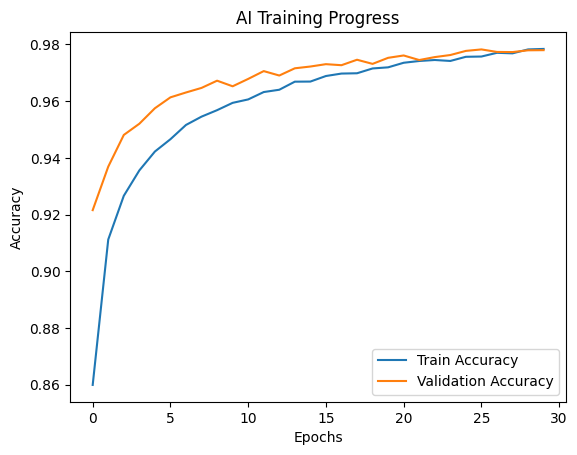

In [16]:
loss, acc, _ = mlp1_model.evaluate(X_test, y_test)

print(f"TEST ACCURACY: {acc*100:.2f}%")

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('AI Training Progress')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

Test Accuracy: 97.86%
Test AUC:      0.9977

602/602 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


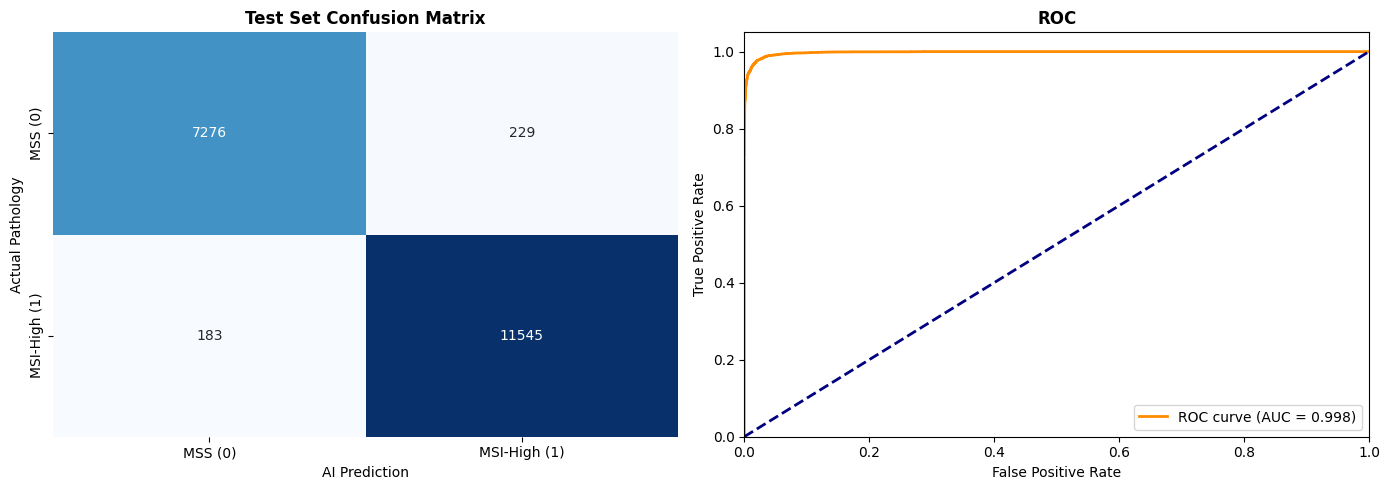

In [18]:

test_loss, test_acc, test_auc = mlp1_model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_acc*100:.2f}%")
print(f"Test AUC:      {test_auc:.4f}\n")


y_pred_probs = mlp1_model.predict(X_test).ravel()
y_pred_classes = (y_pred_probs > 0.5).astype(int)


fig, axes = plt.subplots(1, 2, figsize=(14, 5))


cm = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0], cbar=False,
            xticklabels=['MSS (0)', 'MSI-High (1)'], 
            yticklabels=['MSS (0)', 'MSI-High (1)'])
axes[0].set_title('Test Set Confusion Matrix', fontweight='bold')
axes[0].set_ylabel('Actual Pathology')
axes[0].set_xlabel('AI Prediction')


fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {test_auc:.3f})')
axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC', fontweight='bold')
axes[1].legend(loc="lower right")

plt.tight_layout()
plt.show()

In [19]:
database_embeddings = X_train.astype('float32')
query_embeddings = X_test.astype('float32')

faiss.normalize_L2(database_embeddings)
faiss.normalize_L2(query_embeddings)



In [20]:

index = faiss.IndexFlatL2(dim)
index.add(database_embeddings)
print(f"Searchable vectors: {index.ntotal}")

Searchable vectors: 153849


In [21]:
def evaluate_retrieval_system(index, query_vecs, true_labels, database_labels, k=5):
  
    D, I = index.search(query_vecs, k)
    
    neighbor_labels = database_labels[I] 
    
    
    predicted_labels, _ = mode(neighbor_labels, axis=1, keepdims=True)
    predicted_labels = predicted_labels.flatten()
    
    correct_retrievals = np.sum(predicted_labels == true_labels)
    top_k_accuracy = correct_retrievals / len(true_labels)
    
    return top_k_accuracy, correct_retrievals


In [22]:

k_val = 5
acc, correct = evaluate_retrieval_system(index, query_embeddings, y_test, y_train, k=k_val)

print(f"Total Test Images: {len(y_test)}")
print(f"Correct Retrievals: {correct}")

print(f"Top-{k_val} Accuracy: {acc:.2%}")

if acc > 0.90:
    print("- Conclusion: Your embedding space is HIGHLY SEMANTIC.")
    print("   (Similar patients almost always share the same diagnosis.)")
else:
    print("- Conclusion: Embeddings are somewhat noisy.")

Total Test Images: 19233
Correct Retrievals: 18382
Top-5 Accuracy: 95.58%
- Conclusion: Your embedding space is HIGHLY SEMANTIC.
   (Similar patients almost always share the same diagnosis.)


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


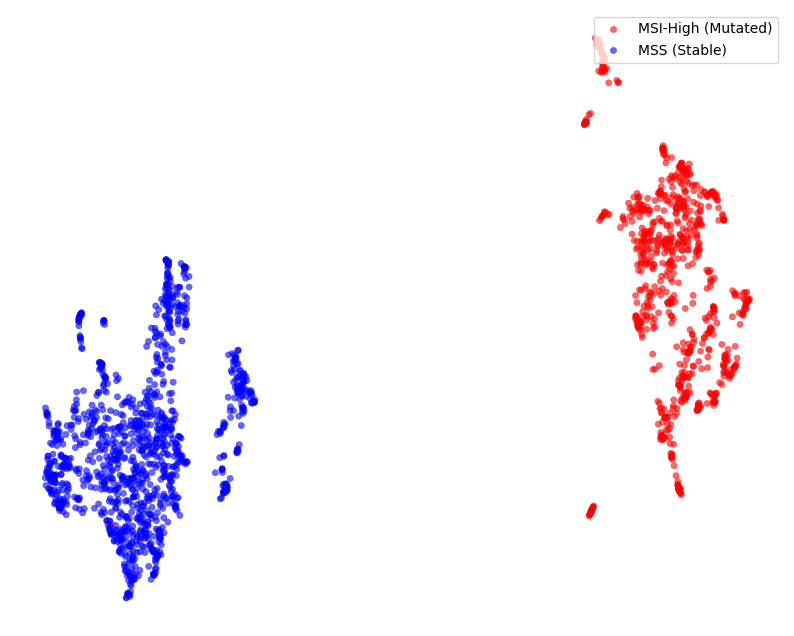

In [23]:
subset_size = 2000
indices = np.random.choice(len(query_embeddings), subset_size, replace=False)

X_subset = query_embeddings[indices]
y_subset = y_test[indices]

labels_text = ["MSI-High (Mutated)" if y==0 else "MSS (Stable)" for y in y_subset]

reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine', random_state=42)
embedding = reducer.fit_transform(X_subset, y=y_subset) 

plt.figure(figsize=(10, 8))
df_sup = pd.DataFrame({
    'UMAP Dimension 1': embedding[:, 0],
    'UMAP Dimension 2': embedding[:, 1],
    'Diagnosis': labels_text
})

sns.scatterplot(
    data=df_sup,
    x='UMAP Dimension 1',
    y='UMAP Dimension 2',
    hue='Diagnosis',
    palette={"MSI-High (Mutated)": "red", "MSS (Stable)": "blue"},
    alpha=0.6,
    s=20,
    edgecolor=None
)

plt.legend(loc='upper right')
plt.axis('off')

plt.show()

Actual Label:   MSS
   Diagnosis: MSS (Stable) (Stability: 99.66%)
PREDICTION: MSS (Confidence: 99.66%)



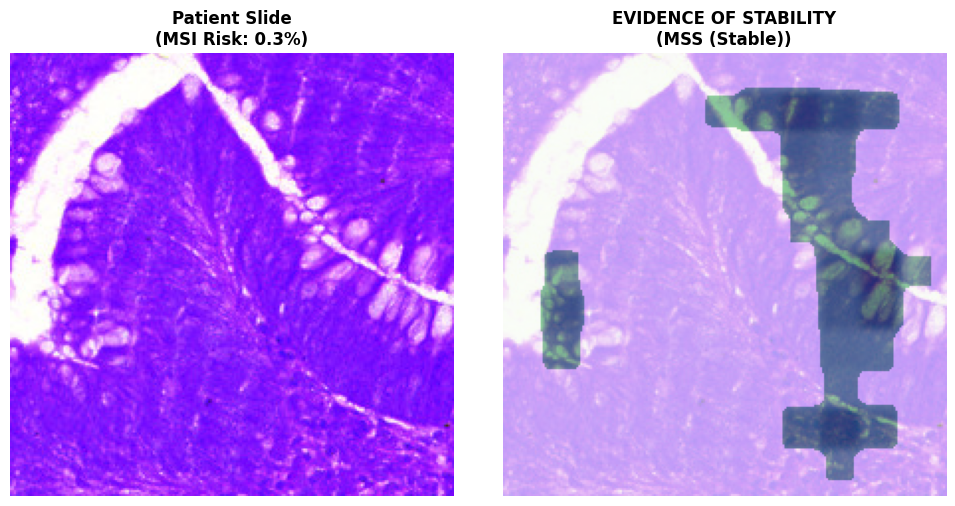

Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


MEDGEMMA IS ANALYZING THE HIGHLIGHTED TISSUE...

--- DIAGNOSIS REPORT ---
Based on the provided image, I would predict this is **MSS (Microsatellite Instability-Stable)**.

Here's my reasoning:

*   **Overall Appearance:** The tissue shows a relatively uniform cellular architecture. There are no obvious signs of significant tumor cell atypia, high mitotic activity, or prominent necrosis that would strongly suggest MSI-High.
*   **Lack of Specific MSI Features:** While I cannot definitively rule out MSI-High without further testing (like immunohistochemistry for mismatch repair proteins), the image doesn't show the characteristic features often associated with MSI-High, such as:
    *   **Tumor budding:** This is a common feature of MSI-High tumors.
    *   **Prominent lymphocytic response:** While lymphocytes can be present in both MSI-High and MSS tumors, a strong lymphocytic infiltrate is more characteristic of MSI-High.
    *   **Specific patterns of cell death:** MSI-High tumors of

In [38]:
def explain_dual_channel(image_path, path_model, medsiglip_model, medsiglip_processor, classifier_model, device="cuda"):
    img = tf.keras.utils.load_img(image_path, target_size=(224, 224))
    img_array = tf.keras.utils.img_to_array(img)
    
    path_serve_fn = path_model.signatures['serving_default']
    
    def get_fused_embedding(current_img_array):
        tensor_tf = tf.expand_dims(current_img_array, 0) / 255.0
        embed_path = path_serve_fn(tensor_tf)['output_0'].numpy()
        
        inputs_pt = medsiglip_processor(images=[current_img_array.astype(np.uint8)], return_tensors="pt").to(device)
        inputs_pt["pixel_values"] = inputs_pt["pixel_values"].to(torch.bfloat16) 
        
        with torch.no_grad():
            outputs_pt = medsiglip_model.vision_model(inputs_pt["pixel_values"])
            embed_med = outputs_pt.pooler_output.float().cpu().numpy()
            
        return np.concatenate([embed_path, embed_med], axis=1)

    base_embed = get_fused_embedding(img_array)
    mss_prob = classifier_model.predict(base_embed, verbose=0)[0][0]
    msi_risk = 1.0 - mss_prob
    
    if msi_risk > 0.50:
        diagnosis_text = "MSI-HIGH (Mutated)"
        mode = "RED_MODE" 
        print(f"   Diagnosis: {diagnosis_text} (Risk: {msi_risk:.2%})")
    else:
        diagnosis_text = "MSS (Stable)"
        mode = "GREEN_MODE" 
        print(f"   Diagnosis: {diagnosis_text} (Stability: {mss_prob:.2%})")
        
    height, width, _ = img_array.shape
    heatmap = np.zeros((height, width))
    patch_size = 40  
    stride = 20      
    
    total_steps = len(range(0, height - patch_size + 1, stride)) * len(range(0, width - patch_size + 1, stride))
    step = 0
    
    for y in range(0, height - patch_size + 1, stride):
        for x in range(0, width - patch_size + 1, stride):
            step += 1
         
            masked_img = img_array.copy()
            masked_img[y:y+patch_size, x:x+patch_size] = 128
            
            masked_embed = get_fused_embedding(masked_img)
            
            masked_mss_prob = classifier_model.predict(masked_embed, verbose=0)[0][0]
            masked_msi_risk = 1.0 - masked_mss_prob
            
            if mode == "RED_MODE":
                importance = msi_risk - masked_msi_risk
            elif mode == "GREEN_MODE":
                importance = masked_msi_risk - msi_risk

            if importance < 0: importance = 0
            heatmap[y:y+patch_size, x:x+patch_size] += importance

    max_importance = np.max(heatmap)
    if max_importance == 0:
        heatmap_final = heatmap
    else:
        heatmap_final = heatmap / max_importance
        heatmap_final = cv2.GaussianBlur(heatmap_final, (11, 11), 0)
        threshold = np.percentile(heatmap_final, 80)
        heatmap_final = np.where(heatmap_final > threshold, heatmap_final, 0)
        if np.max(heatmap_final) > 0:
            heatmap_final = heatmap_final / np.max(heatmap_final)

    return img, heatmap_final, msi_risk, mode

def diagnosis(image_path):
    
    img, heatmap, score, mode = explain_dual_channel(
        image_path=image_path, 
        path_model=path_model, 
        medsiglip_model=medsiglip_model, 
        medsiglip_processor=medsiglip_processor, 
        classifier_model=mlp1_model, 
        device=device
    )

    mlp_diagnosis = "MSI-HIGH" if mode == "RED_MODE" else "MSS"
    mlp_confidence = score if mode == "RED_MODE" else 1.0 - score
    print(f"PREDICTION: {mlp_diagnosis} (Confidence: {mlp_confidence:.2%})\n")
 
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title(f"Patient Slide\n(MSI Risk: {score:.1%})", fontweight='bold')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(img)
    
    if mode == "RED_MODE":
        diagnosis_text = "MSI-HIGH (Mutated)"
        plt.imshow(heatmap, cmap='Reds', alpha=0.6)
        plt.title(f"EVIDENCE OF CANCER\n({diagnosis_text})", fontweight='bold')
    else:
        diagnosis_text = "MSS (Stable)"
        plt.imshow(heatmap, cmap='Greens', alpha=0.6)
        plt.title(f"EVIDENCE OF STABILITY\n({diagnosis_text})", fontweight='bold')
    
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    base_img_uint8 = np.array(img).astype(np.uint8)
    heatmap_norm = heatmap / (np.max(heatmap) + 1e-9)
    
    if mode == "RED_MODE":
        cmap = plt.get_cmap('Reds')
        highlight_color = "red"
    else:
        cmap = plt.get_cmap('Greens')
        highlight_color = "green"
        
    heatmap_color = (cmap(heatmap_norm)[:, :, :3] * 255).astype(np.uint8)
    
    blended_array = cv2.addWeighted(base_img_uint8, 0.7, heatmap_color, 0.6, 0)
    blended_pil = Image.fromarray(blended_array)

    print("MEDGEMMA IS ANALYZING THE HIGHLIGHTED TISSUE...")

    messages_blind = [
        {
            "role": "user",
            "content": [
                {"type": "image"}, 
                {"type": "text", "text": f"You are an expert oncologist and pathologist. Look at this colorectal H&E slide. Our first-stage AI has highlighted specific tissue regions in {highlight_color} based on its mathematical risk analysis.\n\nFirst, based ONLY on your independent visual assessment of the tissue morphology, predict if this is MSI-High or MSS. Second, analyze the specific cellular structures inside the {highlight_color} highlighted regions. What physical features in those specific highlighted areas justify your diagnosis?"}
            ]
        }
    ]

    prompt_blind = medgemma_processor.apply_chat_template(messages_blind, tokenize=False, add_generation_prompt=True)
    
    inputs_blind = medgemma_processor(text=prompt_blind, images=[blended_pil], return_tensors="pt").to(device)
    
    if "pixel_values" in inputs_blind:
        inputs_blind["pixel_values"] = inputs_blind["pixel_values"].to(torch.bfloat16)
    
    with torch.inference_mode():
        outputs_blind = medgemma_model.generate(**inputs_blind, max_new_tokens=250)
    
    input_length = inputs_blind.input_ids.shape[1]
    generated_tokens = outputs_blind[0][input_length:]
    medgemma_independent_report = medgemma_processor.decode(generated_tokens, skip_special_tokens=True)
    
    print("\n--- DIAGNOSIS REPORT ---")
    return medgemma_independent_report.strip()


msi_dir = "/kaggle/input/datasets/linjustin/train-val-test-tcga-coad-msi-mss/tcga_coad_msi_mss/test/MSIMUT"
mss_dir = "/kaggle/input/datasets/linjustin/train-val-test-tcga-coad-msi-mss/tcga_coad_msi_mss/test/MSS"

import random
chosen_dir = random.choice([msi_dir, mss_dir])
ground_truth = "MSI-HIGH" if "MSIMUT" in chosen_dir else "MSS"
random_file = random.choice(os.listdir(chosen_dir))
image_path = os.path.join(chosen_dir, random_file)

print(f"Actual Label:   {ground_truth}")
report = diagnosis(image_path)
print(report)

In [39]:
!pip install gradio

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.6/68.6 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 444.8/444.8 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 55.8 MB/s eta 0:00:00:00:01
  Attempting uninstall: pydantic-core
    Found existing installation: pydantic_core 2.41.5
    Uninstalling pydantic_core-2.41.5:
      Successfully uninstalled pydantic_core-2.41.5
  Attempting uninstall: pydantic
    Found existing installation: pydantic 2.12.5
    Uninstalling pydantic-2.12.5:
      Successfully uninstalled pydantic-2.12.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-adk 1.22.1 requires google-cloud-bigquery-storage>=2.0.0, which is not installed.
langchain-core 0.3.79 requires packaging<26.0.0,>=23.2.0, but you have packaging 26.0rc2 which is incompatible.
fastai 2.8.4 requires fastcore<1.9

In [41]:
import gradio as gr
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import numpy as np
import torch

def predict_for_web(image_path):
    # 1. Run the Explainer
    img, heatmap, score, mode = explain_dual_channel(
        image_path=image_path, 
        path_model=path_model, 
        medsiglip_model=medsiglip_model, 
        medsiglip_processor=medsiglip_processor, 
        classifier_model=mlp1_model, 
        device=device
    )
    
    fig = plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.imshow(np.array(img).astype("uint8"))
    plt.title(f"Patient Slide\n(MSI Risk: {score:.1%})", fontweight='bold')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(np.array(img).astype("uint8"))
    
    if mode == "RED_MODE":
        diagnosis_text = "MSI-HIGH (Mutated)"
        highlight_color = "red"
        cmap = plt.get_cmap('Reds')
        plt.imshow(heatmap, cmap='Reds', alpha=0.6)
        plt.title(f"EVIDENCE OF CANCER\n({diagnosis_text})", fontweight='bold')
    else:
        diagnosis_text = "MSS (Stable)"
        highlight_color = "green"
        cmap = plt.get_cmap('Greens')
        plt.imshow(heatmap, cmap='Greens', alpha=0.6)
        plt.title(f"EVIDENCE OF STABILITY\n({diagnosis_text})", fontweight='bold')
        
    plt.axis('off')
    plt.tight_layout()
    
    base_img_uint8 = np.array(img).astype(np.uint8)
    heatmap_norm = heatmap / (np.max(heatmap) + 1e-9)
    heatmap_color = (cmap(heatmap_norm)[:, :, :3] * 255).astype(np.uint8)
    blended_array = cv2.addWeighted(base_img_uint8, 0.7, heatmap_color, 0.6, 0)
    blended_pil = Image.fromarray(blended_array)

    # 4. Run MedGemma 4B
    messages_blind = [
        {
            "role": "user",
            "content": [
                {"type": "image"}, 
                {"type": "text", "text": f"You are an expert oncologist and pathologist. Look at this colorectal H&E slide. Our first-stage AI has highlighted specific tissue regions in {highlight_color} based on its mathematical risk analysis.\n\nFirst, based ONLY on your independent visual assessment of the tissue morphology, predict if this is MSI-High or MSS. Second, analyze the specific cellular structures inside the {highlight_color} highlighted regions. What physical features in those specific highlighted areas justify your diagnosis?"}
            ]
        }
    ]

    prompt_blind = medgemma_processor.apply_chat_template(messages_blind, tokenize=False, add_generation_prompt=True)
    inputs_blind = medgemma_processor(text=prompt_blind, images=[blended_pil], return_tensors="pt").to(device)
    
    if "pixel_values" in inputs_blind:
        inputs_blind["pixel_values"] = inputs_blind["pixel_values"].to(torch.bfloat16)
    
    with torch.inference_mode():
        outputs_blind = medgemma_model.generate(**inputs_blind, max_new_tokens=250)
    
    input_length = inputs_blind.input_ids.shape[1]
    generated_tokens = outputs_blind[0][input_length:]
    report = medgemma_processor.decode(generated_tokens, skip_special_tokens=True).strip()
    
    return fig, report

with gr.Blocks(theme=gr.themes.Soft()) as demo:
    gr.Markdown("# GemmaSight: Dual-Eye Pathology Assistant")
    gr.Markdown("Upload an H&E histology slide. GemmaSight will extract visual features, generate a spatial occlusion heatmap, and draft a clinical pathology report.")
    
    with gr.Row():
        with gr.Column(scale=1):
            img_input = gr.Image(type="filepath", label="Upload Patient Slide")
            analyze_btn = gr.Button("Analyze Slide", variant="primary")
            
        with gr.Column(scale=2):
            plot_output = gr.Plot(label="Dual-Eye Analysis")
            text_output = gr.Textbox(label="MedGemma 4B Clinical Report", lines=8)
            
    analyze_btn.click(fn=predict_for_web, inputs=img_input, outputs=[plot_output, text_output])

demo.launch(share=True, debug=True)

* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://4522a36356b492a71a.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/protocols/http/h11_impl.py", line 403, in run_asgi
    result = await app(  # type: ignore[func-returns-value]
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/middleware/proxy_headers.py", line 60, in __call__
    return await self.app(scope, receive, send)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/fastapi/applications.py", line 1139, in __call__
    await super().__call__(scope, receive, send)
  File "/usr/local/lib/python3.12/dist-packages/starlette/applications.py", line 107, in __call__
    await self.middleware_stack(scope, receive, send)
  File "/usr/local/lib/python3.12/dist-packages/starlette/middleware/errors.py", line 186, in __call__
    raise exc
  File "/usr/local/lib/python3.12/dist-packages/starlette/middleware/errors.py",

   Diagnosis: MSI-HIGH (Mutated) (Risk: 99.98%)


Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://4522a36356b492a71a.gradio.live


In [80]:
def extract_medgemma_internal(dataset, name):
    print(f"\nStarting MedGemma Internal Extraction for: {name}")
    all_embeddings = []
    all_labels = []
    start_time = time.time()
    
    # 1. Create the dummy prompt ONCE outside the loop
    dummy_messages = [
        {
            "role": "user",
            "content": [
                {"type": "image"}, 
                {"type": "text", "text": "dummy"}
            ]
        }
    ]
    single_dummy_prompt = medgemma_processor.apply_chat_template(dummy_messages, tokenize=False)
    
    for step, (images, labels) in enumerate(dataset):
        
        # 2. Convert TF batch (0-255) to a list of Numpy arrays for the processor
        images_list = list(images.numpy().astype(np.uint8))
        batch_size = len(images_list)
        
        # 3. Create a list of dummy prompts matching the exact batch size
        batch_prompts = [single_dummy_prompt] * batch_size
        
        # THE FIX: Wrap each image in its own list so the processor knows it's 1 image per prompt
        images_batched_for_processor = [[img] for img in images_list]
        
        # 4. Pass the batched text and batched images
        inputs_pt = medgemma_processor(
            text=batch_prompts, 
            images=images_batched_for_processor, 
            return_tensors="pt",
            padding=True # Ensure batched text is padded correctly
        ).to(device)
        
        # Cast to bfloat16 for the MedGemma brain
        inputs_pt["pixel_values"] = inputs_pt["pixel_values"].to(torch.bfloat16)
        
        # 5. THE HACK: Bypass the LLM, pass pixels directly to the vision_tower
        with torch.no_grad():
            vision_outputs = medgemma_model.vision_tower(inputs_pt["pixel_values"])
            
            # Collapse the massive spatial token grid into a flat 1D vector using .mean()
            embeddings_internal = vision_outputs.last_hidden_state.mean(dim=1).float().cpu().numpy()
            
        all_embeddings.append(embeddings_internal)
        all_labels.append(labels.numpy())
        
        # Print progress every 10 batches
        if step % 10 == 0:
            print(f"   Batch {step}: Processed {(step + 1) * batch_size} images...")
            
    # Stack the full dataset
    X = np.vstack(all_embeddings)
    y = np.concatenate(all_labels)
    
    # Save with a unique name so it doesn't overwrite your MLP1 features!
    np.save(f'{name}_medgemma_embeddings.npy', X)
    np.save(f'{name}_medgemma_labels.npy', y)
    
    duration = time.time() - start_time
    print(f"Finished {name} in {duration:.1f} seconds.")
    print(f"Final Shape: {X.shape}")
    return X, y


🧹 SWEEPING THE GPU MEMORY...


AcceleratorError: CUDA error: invalid argument
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
